#BERT without @s and BERT with no @s, hashtags, or http links (the All BERT)


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
! pip install sentencepiece
! pip install transformers
! pip install tensorflow-addons
! pip install tf-models-official
! pip install --upgrade tensorflow-hub

     |████████████████████████████████| 1.2MB 7.7MB/s 
     |████████████████████████████████| 2.2MB 7.7MB/s 
     |████████████████████████████████| 3.3MB 40.1MB/s 
     |████████████████████████████████| 870kB 47.7MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.44-cp37-none-any.whl size=886084 sha256=8b5610f86c50bce9f68aae219f56f8d3f72deed81d2aae86528b3d2e45bcd0ec
  Stored in directory: /root/.cache/pip/wheels/3e/fb/c0/13ab4d63d537658f448366744654323077c4d90069b6512f3c
Successfully built sacremoses
     |████████████████████████████████| 706kB 9.0MB/s 
     |████████████████████████████████| 1.1MB 7.5MB/s 
     |████████████████████████████████| 102kB 8.3MB/s 
     |████████████████████████████████| 174kB 22.1MB/s 
     |████████████████████████████████| 51kB 5.8MB/s 
     |████████████████████████████████| 37.6MB 131kB/s 
     |████████████████████████████████| 645kB 47.8MB/s 
     |████████████████████████████████| 358kB 48.0MB/s 
  Created wheel for py-cpuinfo: filen

In [ ]:
#Utility Functions
import json
import pandas as pd
import numpy as np
import os
import sys
import tensorflow as tf
from time import time
import io
import re
import matplotlib.pyplot as plt

import pickle
from csv import reader
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

#Tensorflow Libraries
from tensorflow.keras import layers
from tensorflow.keras.backend import sparse_categorical_crossentropy
from tensorflow.keras.layers import Dense, Flatten
import tensorflow_hub as hub
from tensorflow.keras import utils

#from datetime import datetime

from collections import defaultdict

import sentencepiece

#Sk-learn functions
from sklearn.model_selection import train_test_split

from transformers import BertTokenizer, TFBertModel, T5Tokenizer, TFT5ForConditionalGeneration
from transformers import TFBertForSequenceClassification
import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization as tokenization
from official.modeling import tf_utils
from official import nlp
from official.nlp import bert

In [ ]:
tf.get_logger().setLevel("ERROR")

###Load Data

In [ ]:
X_train_base = pd.read_csv('/content/gdrive/MyDrive/w266_bot_id_final_project/bot_id_pan/all_data/X_train.csv')
X_dev_base = pd.read_csv('/content/gdrive/MyDrive/w266_bot_id_final_project/bot_id_pan/all_data/X_dev.csv')
X_test_base = pd.read_csv('/content/gdrive/MyDrive/w266_bot_id_final_project/bot_id_pan/all_data/X_test.csv')
X_earlybird_base = pd.read_csv('/content/gdrive/MyDrive/w266_bot_id_final_project/bot_id_pan/all_data/X_earlybird.csv')
y_train_base = pd.read_csv('/content/gdrive/MyDrive/w266_bot_id_final_project/bot_id_pan/all_data/y_train.csv')
y_dev_base = pd.read_csv('/content/gdrive/MyDrive/w266_bot_id_final_project/bot_id_pan/all_data/y_dev.csv')
y_test_base = pd.read_csv('/content/gdrive/MyDrive/w266_bot_id_final_project/bot_id_pan/all_data/y_test.csv')
y_early_bird_base = pd.read_csv('/content/gdrive/MyDrive/w266_bot_id_final_project/bot_id_pan/all_data/y_earlybird.csv')

###Remove unneccessary columns and convert pandas dataframe to numpy array

In [ ]:
X_train_base = X_train_base['tweets']
X_dev_base = X_dev_base['tweets']
X_earlybird_base = X_earlybird_base['tweets']
X_test_base = X_test_base['tweets']
y_train_base = y_train_base['bot']
y_dev_base = y_dev_base['bot']
y_test_base = y_test_base['bot']
y_early_bird_base = y_early_bird_base['bot']
X_train_base, X_dev_base, y_train_base, y_dev_base = np.array(X_train_base),np.array(X_dev_base),np.array(y_train_base), np.array(y_dev_base)
X_test_base, y_test_base = np.array(X_test_base), np.array(y_test_base)

In [ ]:
import re
ree = " I Love the UK mate"
a = "I really want to go back to the UK"
d = "I love England"
e = "Ree ree UK yes"
arr = np.array([ree, a, d, e])
sum([len(re.findall("UK", string)) for string in arr])

3

### Convert outcome variable to categorical

In [ ]:
def to_categorical(y_data):
  "Converts outcome to categorical"
  return utils.to_categorical(y_data)

y_train = to_categorical(y_train_base)
y_dev = to_categorical(y_dev_base)
y_test = to_categorical(y_test_base)
y_earlybird = to_categorical(y_early_bird_base)

### Encode Model

In [ ]:
def make_bert_layers():
  "Established Bert Process"
  bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/2",
                             trainable=True)
  vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
  do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
  tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)
  return bert_layer, vocab_file, do_lower_case, tokenizer

def encode_names(tweet, tokenizer):
   tokens = list(tokenizer.tokenize(tweet))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

def bert_encode(string_list, tokenizer, max_seq_length):
  num_examples = len(string_list)
  
  string_tokens = tf.ragged.constant([
      encode_names(tweet, tokenizer) for tweet in np.array(string_list)])

  cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*string_tokens.shape[0]
  input_word_ids = tf.concat([cls, string_tokens], axis=-1)

  input_mask = tf.ones_like(input_word_ids).to_tensor(shape=(None, max_seq_length))

  type_cls = tf.zeros_like(cls)
  type_tokens = tf.ones_like(string_tokens)
  input_type_ids = tf.concat(
      [type_cls, type_tokens], axis=-1).to_tensor(shape=(None, max_seq_length))

  inputs = {
      'input_word_ids': input_word_ids.to_tensor(shape=(None, max_seq_length)),
      'input_mask': input_mask,
      'input_type_ids': input_type_ids}

  return inputs

### Make Model

In [ ]:
def bert_model(max_length):
  "Makes Bert Model"
  bert_layer, vocab_file, do_lower_case, tokenizer= make_bert_layers()
  num_class = 2  # Based on available class selection
  max_length = max_length  # we calculated this a couple cells ago

  input_word_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32,
                                       name="input_word_ids")
  input_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32,
                                   name="input_mask")
  segment_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32,
                                    name="segment_ids")

  pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])                                

  output = tf.keras.layers.Dropout(rate=0.15)(pooled_output)

  output = tf.keras.layers.Dense(num_class, activation='sigmoid', name='output')(output)

  model = tf.keras.Model(
    inputs={
        'input_word_ids': input_word_ids,
        'input_mask': input_mask,
        'input_type_ids': segment_ids
        },
        outputs=output)
  return model, max_length, tokenizer
model, max_length, tokenizer = bert_model(200)

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 200)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 200)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 200)]        0                                            
__________________________________________________________________________________________________
keras_layer_1 (KerasLayer)      [(None, 768), (None, 177853441   input_word_ids[0][0]             
                                                                 input_mask[0][0]           

### Visualize Model

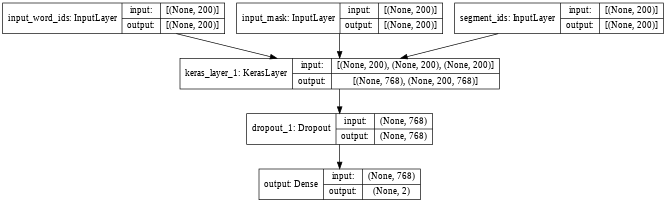

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=48)

### Training Model Function

In [ ]:
def train_model_evaluate(X_train_encoded, X_dev_encoded, y_train, y_dev ,epochs, batch_size, loss_function):
  "Trains bert model"
  eval_batch_size = batch_size
  train_data_size = len(y_train)
  steps_per_epoch = int(train_data_size / batch_size)
  num_train_steps = steps_per_epoch * epochs
  warmup_steps = int(epochs * train_data_size * 0.1 / batch_size) 
  optimizer = nlp.optimization.create_optimizer(
    2e-6, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps)
  model.compile(optimizer=optimizer,
              loss=loss_function,
              metrics=['accuracy'])
  model_history = model.fit(X_train_encoded,  # using new training set
                         y_train,  # using new training set
                         epochs=epochs,
                         batch_size=batch_size,
                         validation_data=(X_dev_encoded, y_dev),  # using old test dataset
                         verbose=1)
  return model_history

### Evaluate Model Function

In [ ]:
def evaluate_model(X_test_encoded, y_test, batch_size):
  "Evaluates on the test set"
  score, accuracy = model.evaluate(X_test_encoded, y_test, batch_size = batch_size)
  return score, accuracy

## BERT without @s

### Encode, Run, and Evaluate Base Model

In [ ]:
X_train_base_no_ats= np.array([tweet.replace('@', '') for tweet in X_train_base])
X_dev_base_no_ats = np.array([tweet.replace('@', '') for tweet in X_dev_base])
X_test_base_no_ats = np.array([tweet.replace('@', '') for tweet in X_test_base])

In [ ]:
X_train_encoded_no_ats = bert_encode(X_train_base_no_ats, tokenizer, max_length)
X_dev_encoded_no_ats = bert_encode(X_dev_base_no_ats, tokenizer, max_length)
X_test_encoded_no_ats = bert_encode(X_test_base_no_ats, tokenizer, max_length)

In [ ]:
model_history = train_model_evaluate(X_train_encoded_no_ats,X_dev_encoded_no_ats, y_train, y_dev, 3, 16, 'binary_crossentropy')

INFO:absl:using Adamw optimizer
INFO:absl:gradient_clip_norm=1.000000


Epoch 1/3
17253/17253 [==============================] - 4781s 276ms/step - loss: 0.3848 - accuracy: 0.8232 - val_loss: 0.1866 - val_accuracy: 0.9425
Epoch 2/3
17253/17253 [==============================] - 4765s 276ms/step - loss: 0.1819 - accuracy: 0.9446 - val_loss: 0.1738 - val_accuracy: 0.9534
Epoch 3/3
17253/17253 [==============================] - 4760s 276ms/step - loss: 0.1572 - accuracy: 0.9569 - val_loss: 0.1765 - val_accuracy: 0.9562


In [ ]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

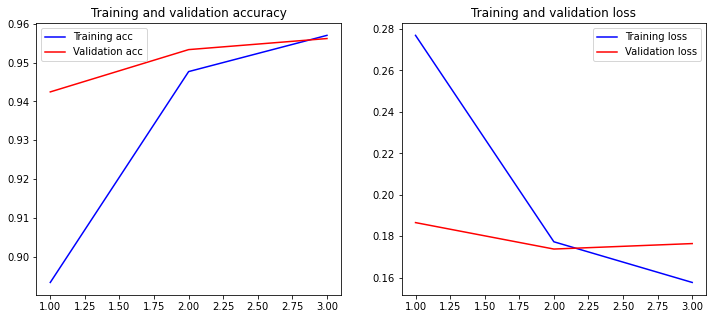

In [ ]:
plot_history(model_history)

In [ ]:
test_score, test_accuracy = evaluate_model(X_test_encoded_no_ats, y_test, 16)
test_score, test_accuracy

16500/16500 [==============================] - 1197s 73ms/step - loss: 0.7367 - accuracy: 0.8373


(0.7367386221885681, 0.8373371362686157)

### Save Base Model

In [ ]:
model_fname = 'bert_no_ats'
my_wd = '/content/gdrive/MyDrive/w266_bot_id_final_project/bot_id_pan/'

model.save(os.path.join(my_wd, model_fname))

## BERT with Hashtags

### Encode, Run, and Evaluate BERT Model without Hashtags, @, and http (All BERT)

In [ ]:
def remove_all(data):
  data_no_links = np.array([re.sub(r"http\S+", "", tweet) for tweet in data])
  data_no_links_no_hashtags = np.array([tweet.replace('#', '')for tweet in data_no_links])
  data_no_all = np.array([tweet.replace('@', '')for tweet in data_no_links_no_hashtags])
  return data_no_all

In [ ]:
X_train_base_no_all = remove_all(X_train_base)
X_dev_base_no_all = remove_all(X_dev_base)
X_test_base_no_all= remove_all(X_test_base)

In [ ]:
X_train_encoded_no_all = bert_encode(X_train_base_no_all, tokenizer, max_length)
X_dev_encoded_no_all = bert_encode(X_dev_base_no_all, tokenizer, max_length)
X_test_encoded_no_all = bert_encode(X_test_base_no_all, tokenizer, max_length)

In [ ]:
model_history = train_model_evaluate(X_train_encoded_no_all,X_dev_encoded_no_all, y_train, y_dev, 3, 16, 'binary_crossentropy')

INFO:absl:using Adamw optimizer
INFO:absl:gradient_clip_norm=1.000000


Epoch 1/3
17253/17253 [==============================] - 4781s 276ms/step - loss: 0.4074 - accuracy: 0.8019 - val_loss: 0.2004 - val_accuracy: 0.9291
Epoch 2/3
17253/17253 [==============================] - 4768s 276ms/step - loss: 0.1996 - accuracy: 0.9322 - val_loss: 0.1938 - val_accuracy: 0.9400
Epoch 3/3
17253/17253 [==============================] - 4768s 276ms/step - loss: 0.1761 - accuracy: 0.9446 - val_loss: 0.2003 - val_accuracy: 0.9418


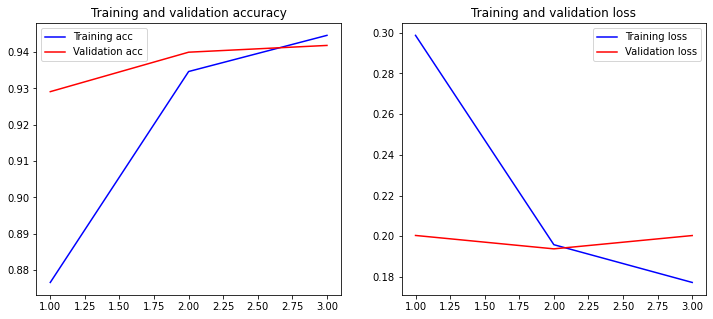

In [ ]:
plot_history(model_history)

In [ ]:
test_score, test_accuracy = evaluate_model(X_test_encoded_no_all, y_test, 16)
test_score, test_accuracy

16500/16500 [==============================] - 1205s 73ms/step - loss: 0.7362 - accuracy: 0.8171


(0.7361553907394409, 0.8171401619911194)

### Save BERT Model with Hashtags

In [ ]:
model_fname = 'bert_no_all'
my_wd = '/content/gdrive/MyDrive/w266_bot_id_final_project/bot_id_pan/'

model.save(os.path.join(my_wd, model_fname))